In [1]:
from IPython.core.display import HTML;css_file = '../../my.css';HTML(open(css_file, "r").read())

In [2]:
# import some needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
from pylab import *
rcParams['figure.figsize'] = (7, 7)
font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
# this command makes sure we can plot inline in the notebook
%matplotlib inline

## Principal Component Analysis (PCA)

### PCA for heart disease classification

### The data

In [4]:
# load the data from a text file
heart = pd.read_table('heart.txt', header=0)

#### Explore the data

#### Description of the data
0. age: age in years
- sex: sex
    + 1 = male
    + 0 = female
- cp: chest pain type
    + 1 = typical angina
    + 2 = atypical angina
    + 3 = non-anginal pain
    + 4 = asymptomatic
- trestbps: resting blood pressure in mm Hg
- chol: serum cholestoral in mg/dl
- fbs: fasting blood sugar > 120 mg/dl
    + 1 = true
    + 0 = false
- restecg: resting electrocardiographic results
    + 0 = normal
    + 1 = having ST-T wave abnormality
    + 2 = showing probable or definite left ventricular hypertrophy
- thalach: maximum heart rate achieved
- exang: exercise induced angina
    + 1 = yes
    + 0 = no
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
    + 1 = upsloping
    + 2 = flat
    + 3 = downsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal: thallium scan -- the myocardial perfusion pattern 
    + 3 = normal
    + 6 = fixed defect
    + 7 = reversable defect
- target: diagnosis of heart disease
    + 0 = healthy subject
    + 1 = ill subject

- **Exercise 1**: Explore the data: print the number of samples, the number of features. How many samples does the dataset contain? How many features?    


    303 subjects and 13 features (last column in our target variable!)
                    
**Which variables are categorical? Which ones are continuous?**

    some examples: sex and chest pain are categorical, while age and cholesterol level are continuous.

In [5]:
print heart.shape

(303, 14)


In [6]:
print heart.head()

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

  ca thal  target  
0  0    6       0  
1  3    3       1  
2  2    7       1  
3  0    3       0  
4  0    3       0  


- **Exercise 2**: How many healthy subjects are in the dataset? How many ill subjects? (tip: call the *pd.value_counts* function on the *heart.target* column).


    164 healthy subjects and 139 ill subjects

In [7]:
pd.value_counts(heart.target)

0    164
1    139
Name: target, dtype: int64

#### Visualize the data

In [8]:
# we need some colors for our plots!
colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'pink', 'orange', 'purple']
from itertools import cycle

Our dataset contains both *continuos* and *categorical* variables.

Because we will visualize them in a different way, let's split the dataset like this:

In [9]:
# the continuous variables
continuous = heart[['age','trestbps', 'chol', 'thalach', 'oldpeak']]
# the categorical variables
categorical = heart[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']]

In [10]:
print continuous.head

<bound method DataFrame.head of      age  trestbps  chol  thalach  oldpeak
0     63       145   233      150      2.3
1     67       160   286      108      1.5
2     67       120   229      129      2.6
3     37       130   250      187      3.5
4     41       130   204      172      1.4
5     56       120   236      178      0.8
6     62       140   268      160      3.6
7     57       120   354      163      0.6
8     63       130   254      147      1.4
9     53       140   203      155      3.1
10    57       140   192      148      0.4
11    56       140   294      153      1.3
12    56       130   256      142      0.6
13    44       120   263      173      0.0
14    52       172   199      162      0.5
15    57       150   168      174      1.6
16    48       110   229      168      1.0
17    54       140   239      160      1.2
18    48       130   275      139      0.2
19    49       130   266      171      0.6
20    64       110   211      144      1.8
21    58       150   2

Let's start with a boxplot of our _continuous_ variables:

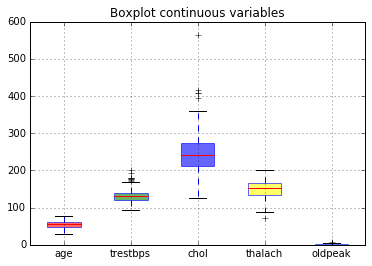

In [11]:
bp = continuous.boxplot(patch_artist=True)
for patch, color in zip(bp['boxes'], cycle(colors)):
    patch.set_facecolor(color)
    patch.set_alpha(.6)
plt.title('Boxplot continuous variables')

- **Exercise 3**: What can you say about the distribution of these features? Do you think any sort of data pre-processing is required before performing a PCA?


    distributions are very different! PCA needs the data to be standardized!!

And now some barplots for our _categorical_ variables:

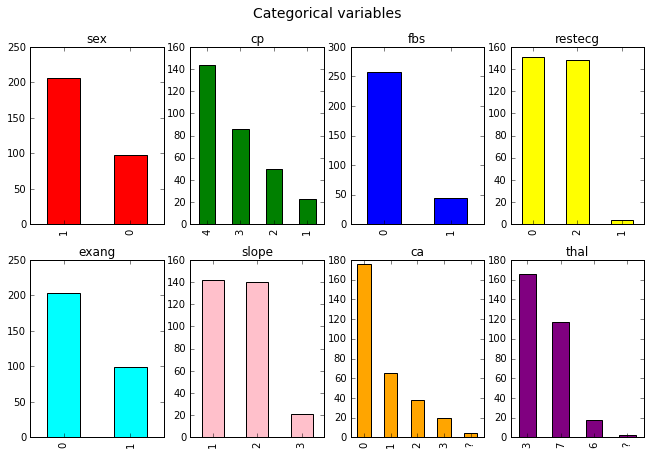

In [12]:
fig = plt.figure(figsize=(11,7))
fig.suptitle('Categorical variables', fontsize=14)
# loop for the plotting
for i in range(len((categorical.columns))):
    vec = categorical[categorical.columns[i]]
    ax = plt.subplot(2, 4, i+1)
    vec.value_counts().plot(ax=ax, kind='bar', color=colors[i], title=categorical.columns[i])

- **Exercise 4**: Do you see anything strange in the values of the two variables _major vessels_ and _thallium scan_? What?


    the ? indeed; it is annotating the missing points in the dataset

#### Dealing with missing data

In [13]:
# let's convert the dataframe to a numpy array (just for convenience!)
heart_data = heart.values
i = np.where(heart_data=='?')[0]
print 'The dataset contains %i missing values' %len(i)

print i

The dataset contains 6 missing values
[ 87 166 192 266 287 302]


In [14]:
# a list of True and False to flag if a value is missing or not
missing = np.in1d(range(heart_data.shape[0]), i)

print missing
# now we remove the missing values
heart_data_clean = heart_data[~missing]

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

- **Exercise 5**: How many samples does the dataset contain after missing data removal?

    
    297 samples

In [15]:
print heart_data_clean.shape

(297, 14)


In [16]:
# let's now skip the last column (which is the target, and not a feature)
X = heart_data_clean[:, 0:heart_data_clean.shape[1]-1] 
X = np.array(X, dtype=float)
# our y (target) vector is the last column
y = np.asarray(heart_data_clean[:, heart_data_clean.shape[1]-1], dtype=int)

### Principal Component Analysis

Let's run a PCA on our data set with the **sklearn** package:

In [17]:
# import the library
from sklearn.decomposition import PCA

In [18]:
# create a model and fit and transform the data
pca = PCA()
X_pca = pca.fit_transform(X)

#### Inspecting the PCA results

Let's have a look at the the proportion of variance explained by each component:

In [19]:
print pca.explained_variance_ratio_

[  7.46243578e-01   1.49787648e-01   8.57955289e-02   1.60023313e-02
   1.01307682e-03   3.30072242e-04   2.50801576e-04   2.22000205e-04
   1.76402998e-04   5.92782847e-05   4.75020518e-05   4.06039465e-05
   3.11751680e-05]


- **Exercise 6**: Which is the percentage of variance explained by the first component? And the one explained by the second?
    
        74%, 15%

In order to decide how many principal components you should retain, you can summarise the results of the performed PCA by making a **scree plot**.  A scree plot shows the fraction of total variance in the data as explained or represented by each PC.

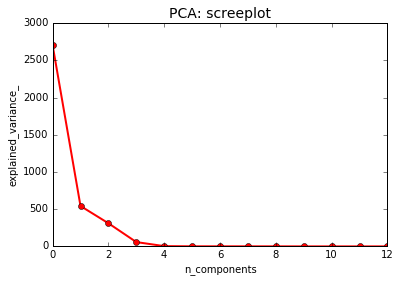

In [20]:
# render the screeplot
plt.plot(pca.explained_variance_, 'ro-', linewidth=2)
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.title('PCA: screeplot', fontsize=14)

- **Exercise 7**: How many components do you think are needed to explain most of the variance of this dataset?

        the second component does not add a lot of information, and the third even less. It seems here that the first two components are enough!

#### Visualize the data projection

In [21]:
diagnose = y
diagnose_labels = ('healthy', 'ill')

In [22]:
exercise = np.asarray(heart_data_clean[:, 8], dtype = int)
exercise_labels = ('exercise induced angina', 'non-exercise induced angina')

We define a function to quickly plot the data projection onto 2D:

In [23]:
def plot2D(data, target, labels, atitle):
    fig, ax1 = plt.subplots(figsize=(7,7))
    plt.xlabel('coord 1')
    plt.ylabel('coord 2')
    for i, c in zip(np.unique(target), cycle(colors)):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                  s=50, alpha=.6, c=c, label='%s - %s' %(i, labels[i]))
    plt.legend()
    plt.title(atitle)

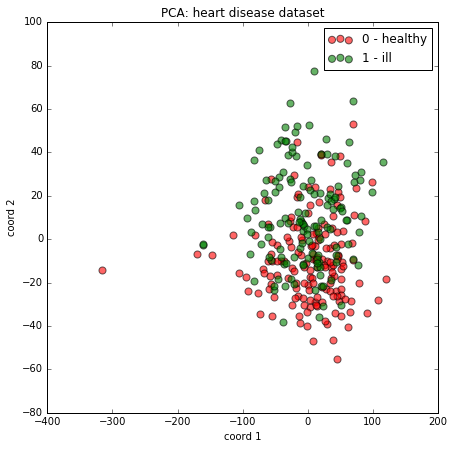

In [24]:
# let's plot the components highlighting healthy and ill subjects 
plot2D(X_pca, diagnose, diagnose_labels, 'PCA: heart disease dataset')

What you should have at this step is a projection of your 13 features samples on just 2 dimensions.
However, the two classes do not seem nicely separated one from the other. This happened because we did not standardize our data! 

So let's see what happens if we standardize the data set:

#### Standardize the data

In [25]:
# import the library
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [26]:
# we scale the dataset and store it as a dataframe
X_stand = StandardScaler().fit_transform(X)
stand = pd.DataFrame(X_stand, columns=heart.columns[0: len(heart.columns)-1])

- **Exercise 8**: Using some code from above (copy and paste!) make a boxplot of the continuous variables. How does the standardization affect the features?


     the standardization scales the features so that their mean value is zero and their standard deviation is one

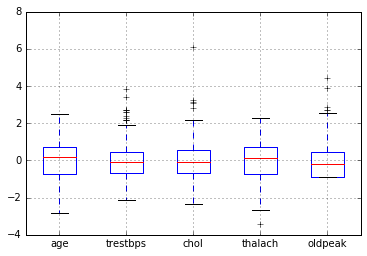

In [27]:
continuous_stand = stand[['age','trestbps', 'chol', 'thalach', 'oldpeak']]
bs = continuous_stand.boxplot()

Let's now run another PCA on our standardized data this time:

In [28]:
X_pca_stand = pca.fit_transform(X_stand)

- **Exercise 9**: Make a screeplot for the PCA just obtained.


     you see now that the variance explained is different, and that the first 3 components seem to be useful the represent the data!

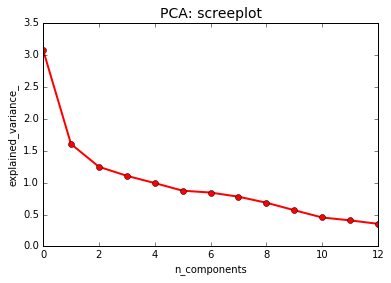

In [29]:
plt.plot(pca.explained_variance_, 'ro-', linewidth=2)
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.title('PCA: screeplot', fontsize=14)

And the new data projection is:

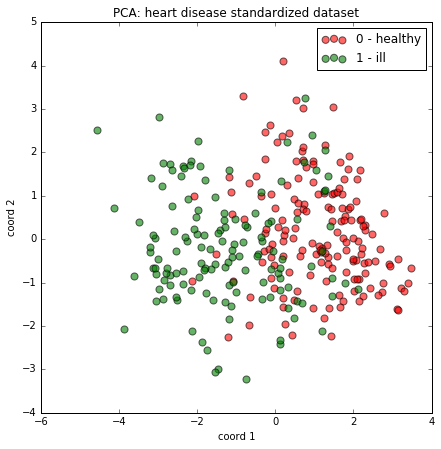

In [30]:
plot2D(X_pca_stand, diagnose, diagnose_labels, 'PCA: heart disease standardized dataset')

The two classes are now more easily separable from each other.

Now we take only the components associated with ill subjects (where diagnose==1), and we plot the 2D projection accordingly:


In [31]:
pca_ill = X_pca_stand[diagnose==1,:]
# and these are the 'exercise' values for the ill subjects
exercise_ill = exercise[diagnose==1]

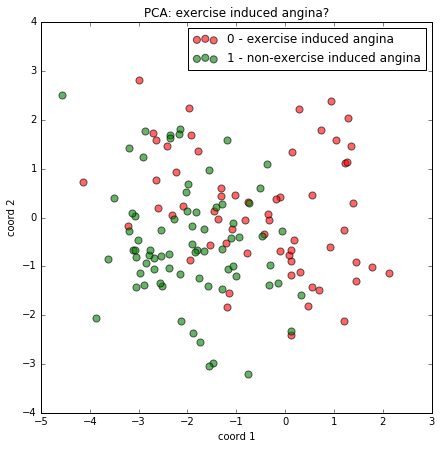

In [32]:
# now we plot the components for the ill subjects, highlighting if they had an exercise-induced angina or not
plot2D(pca_ill, exercise_ill, exercise_labels, 'PCA: exercise induced angina?')

- **Exercise 10**: Do you think is it reasonably easy to classify ill subjects in those who had an exercise-induced angina and those who did not?


    this seems to be a non-trivial task!

# Multi Dimensional Scaling (MDS)

## MDS for heart disease classification

We will first use MDS to visualize the heart disease dataset we just analyzed.

In [33]:
# import the library we will need
from sklearn import manifold

In [34]:
mds = manifold.MDS(n_components=2)

In [35]:
# run the MDS
Y_mds = mds.fit_transform(X_stand)

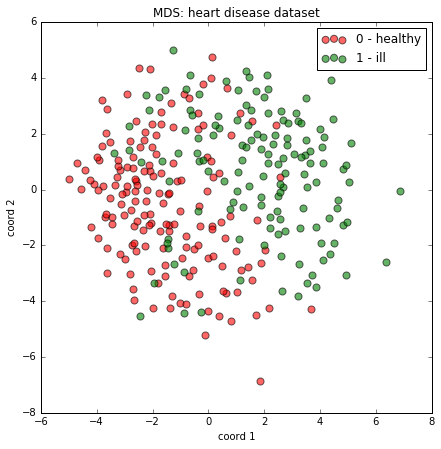

In [36]:
# plot the 2D projection (we can simply reuse the function we defined before!)
plot2D(Y_mds, diagnose, diagnose_labels, 'MDS: heart disease dataset')

- **Exercise 11**: This 2D projection is somehow different from the one obtained through a PCA. Can you explain how the two techniques are different?


    remember: PCA tries to retain most of the variance of the data points, while MDS tries to preserve as much as possible distances between points (points close to each other in the original space are also close to each other in the mapped space) 

## MDS for biological response prediction

We will now use MDS for a different dataset.

### The data

In [37]:
# load the data from a text file
response = pd.read_csv('biol_response.csv', header=0)

In [38]:
print response.shape

(3751, 1777)


- **Exercise 12**: Have a look at the data. How many samples does this dataset contain? How many features?


    the dataset contains 3751 samples, with 1776 features (the first column in the target (Activity))

###**Description of the biological response dataset**
This dataset has been used in a _kaggle_ competition to predict biological response of molecules from their chemical properties.
Each row in this data set represents a molecule. The first column contains experimental data describing an actual biological response; the molecule was seen to elicit this response (1), or not (0). The remaining columns represent molecular descriptors (d1 through d1776), these are calculated properties that can capture some of the characteristics of the molecule - for example size, shape, or elemental constitution. The descriptor matrix has been normalized. For more information on the challenge: https://www.kaggle.com/c/bioresponse.

- **Exercise 13**: Get the unique counts of the _Activity_ variable (again use some code from above!). How many active samples does the dataset contain? How many inactive samples?


    there are 2034 active molecules, and 1717 inactive molecules

In [39]:
pd.value_counts(response.Activity)

1    2034
0    1717
Name: Activity, dtype: int64

#### Visualize the data

This is a big dataset, let's just randomly pick up 50 variables and plot them:

In [40]:
columns = np.random.choice(response.columns.values, 50)

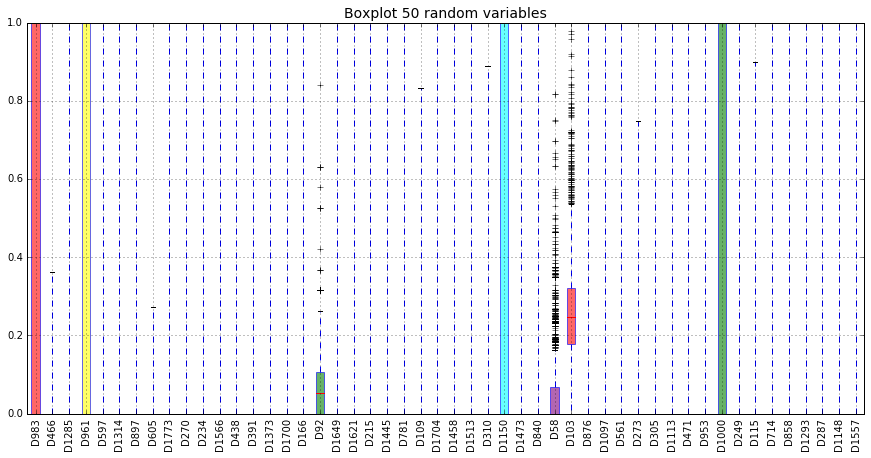

In [41]:
plt.figure(figsize=(15,7))
bp = response[columns].boxplot(patch_artist=True)
plt.xticks(rotation=90) # set the label on the x axis rotated in vertical
for patch, color in zip(bp['boxes'], cycle(colors)):
    patch.set_facecolor(color)
    patch.set_alpha(.6)
plt.title('Boxplot 50 random variables', fontsize=14)

- **Exercise 14**: This dataset is already normalized. Can you explain in which way? Which normalization method has been applied to the data?


    a range scaling has been applied, so that the features are all in the same range, in this case [0, 1]

In [42]:
# we now convert the dataframe to a numpy array
X = response.values
X = X [:, 1:X.shape[1]] #skip first column
activity = np.asarray(response.Activity) # numeric target (y)
activity_labels = ('inactive', 'active')

Now we run the MDS: this is a big dataset, it will take some time...

In [43]:
Y_mds = mds.fit_transform(X)

We can now just use the same function of before and plot the 2D projection:

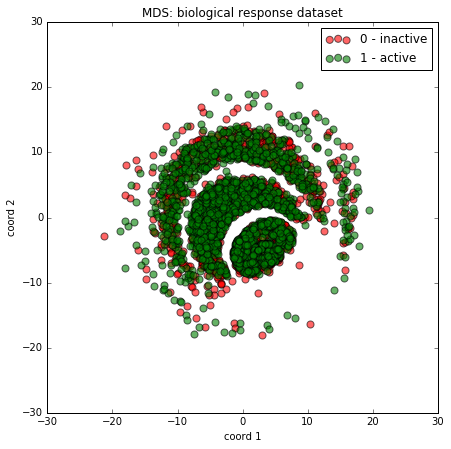

In [44]:
plot2D(Y_mds, activity, activity_labels, 'MDS: biological response dataset')

This doesn't look too nice, does it? There are clearly some clusters, but the overlapping between active and inactive samples is too big to be able to actually tell the two classes apart. The MDS is clearly not the most appropriate technique to visualize this dataset.

## MDS for Yeast Gene Expression Classification

Let's see if the MDS does a better job on Yeast gene expression data.

In [45]:
# import the file from a text file
yeast = pd.read_table('yeast.csv', sep = ' ', header=0)

In [46]:
print yeast.shape

(605, 82)


In [47]:
print yeast.head

<bound method DataFrame.head of          ORF  alpha.0  alpha.7  alpha.14  alpha.21  alpha.28  alpha.35  \
0    YBR009C    -2.84    -3.18     -1.94     -0.64      1.04      1.17   
1    YDR224C    -1.94    -2.00     -1.79     -0.40      0.86      0.72   
2    YDR225W    -2.00    -2.84     -1.94     -0.81      0.86      0.64   
3    YNL031C    -2.25    -1.89     -2.00     -0.43      0.40      0.82   
4    YPL127C    -2.12    -2.00     -0.45      0.43      0.78      0.86   
5    YCR040W    -0.29     0.31     -0.20     -0.04     -0.38      0.11   
6    YCR065W    -1.22    -0.23      0.54      0.66      0.18      0.07   
7    YER088C    -0.38    -0.47     -0.89     -0.76     -0.86     -0.81   
8    YER164W    -0.18    -0.12     -0.22      0.03     -0.09      0.16   
9    YKR099W    -0.49    -0.51     -1.22     -1.00     -0.97     -0.67   
10   YPL177C     0.58    -0.14     -0.34     -0.49     -0.09      0.11   
11   YAL015C    -0.10    -0.12      0.01     -0.34     -0.23      0.14   
12   Y

- **Exercise 15**: Have a look at the data. How many samples does this dataset contain? How many features?


    we have 605 genes (samples) and 82 columns in total, but one column is for the ORF, and the last two are for the Label and the gene class, so we have 82-3=79 features

#### Visualize the data

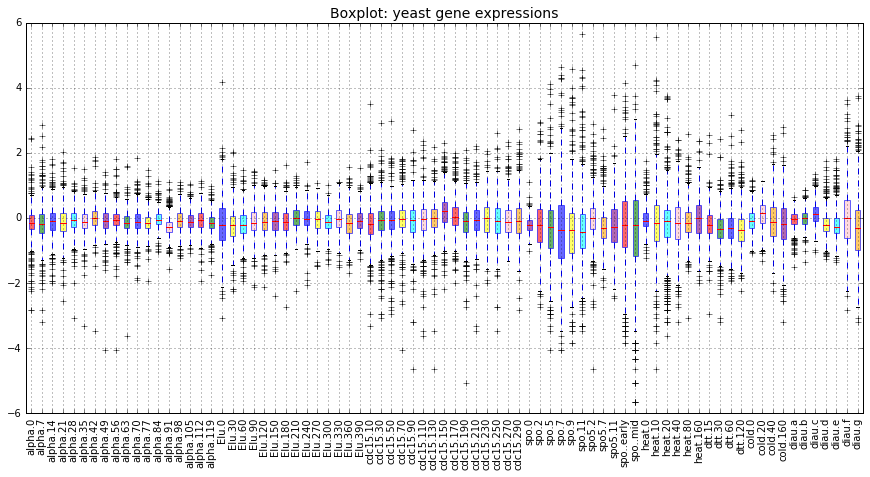

In [48]:
plt.figure(figsize=(15,7))
cols = [col for col in yeast.columns if col not in ['gene_class']]
bp = yeast[cols].boxplot(patch_artist=True)
plt.xticks(rotation=90)
for patch, color in zip(bp['boxes'], cycle(colors)):
    patch.set_facecolor(color)
    patch.set_alpha(.6)
plt.title('Boxplot: yeast gene expressions', fontsize=14)

- **Exercise 16**: Do the features have all the same range? If yes, which one?


    yes, [-6, 6]

- **Exercise 17**: Get the unique counts of the Label variable. How many classes are there for the genes? Which is the most abundant class?

    
    most of the genes are non classified (nc, 524); there are 5 classes, and the most abundant one is the Ribo class

In [49]:
pd.value_counts(yeast.Label)

nc         524
Ribo        49
Resp        13
Proteas      8
HTH          6
Hist         5
Name: Label, dtype: int64

In [50]:
# let's get rid of some columns we do not need for the MDS
cols = [col for col in yeast.columns if col not in ['ORF', 'Label','gene_class']]
X = np.asarray(yeast[cols])

In [51]:
# run the MDS
Y_mds = mds.fit_transform(X)

In [52]:
gene_class = np.asarray(yeast.gene_class)
gene_labels = pd.unique(yeast.Label)

print gene_class
print gene_labels

[0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

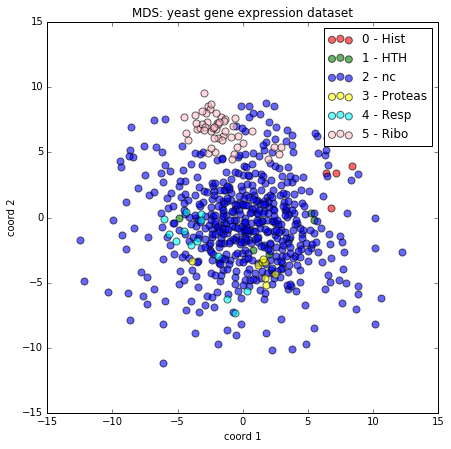

In [53]:
# plot the 2D projection
plot2D(Y_mds, gene_class, gene_labels, 'MDS: yeast gene expression dataset')

Let's just focus on _Ribo_ and _nc_ (non-classified) genes, and look at the 2D projection.

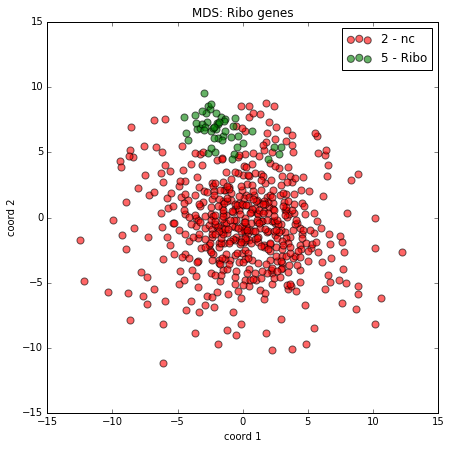

In [54]:
subset_mds = Y_mds[(gene_class==2)|(gene_class==5),:]
subset_gene_class = gene_class[(gene_class==2)|(gene_class==5)]
plot2D(subset_mds, subset_gene_class, gene_labels, 'MDS: Ribo genes')

- **Exercise 18**: Can you easily distinguish the Ribo genes from the rest?


    pretty much, yes


- **Exercise 19**: By default, the __Euclidean__ distance is used in the MDS to compute the dissimilarities between the data points. Do you know any other metrics that could be used instead to represent similarities/dissimilarities?


    We mentioned Pearson coefficient, cosine similarity